In [56]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Clear Keras session to release memory
K.clear_session()

# If you're using TensorFlow, you can also clear GPU memory using the following:

# Get the current TensorFlow session and close it
session = tf.compat.v1.Session()
session.close()

# Reinitialize the session after clearing memory
tf.compat.v1.reset_default_graph()


I0000 00:00:1733313373.672701  147255 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47025 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:9e:00.0, compute capability: 7.5


In [57]:
#Necessary imports

import cv2 #for image processing
import matplotlib.pyplot as plt #for plotting loss and accuracy
import numpy as np #for computations
import os #for loading data
import random #shuffling the data to avoid bias
import pywt #for wavelet transform

#import tensorflow modules
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.utils import shuffle


In [58]:
#Functions for preprocessing

# Load all images from REAL and FAKE directories
def load_balanced_images_from_directory(real_dir, fake_dir, label_real=0, label_fake=1, image_size=(32, 32)):
    real_images, fake_images = [], []
   
    # Load REAL images
    real_filenames = os.listdir(real_dir)
    random.shuffle(real_filenames)
    for filename in real_filenames:
        img_path = os.path.join(real_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, image_size)  # Resize image
            image = image / 255.0  # Normalize
            real_images.append(image)
   
    # Load FAKE images
    fake_filenames = os.listdir(fake_dir)
    random.shuffle(fake_filenames)
    for filename in fake_filenames:
        img_path = os.path.join(fake_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, image_size)  # Resize image
            image = image / 255.0  # Normalize
            fake_images.append(image)

    images = np.array(real_images + fake_images)
    labels = np.array([label_real] * len(real_images) + [label_fake] * len(fake_images))
   
    return images, labels

# Extract wavelet features from an image
def extract_wavelet_features(image, wavelet='bior1.3'):
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2  # Decompose into 4 sub-bands (LL, LH, HL, HH)
   
    # Flatten each coefficient and concatenate them into a feature vector
    LL_flat = LL.flatten()
    LH_flat = LH.flatten()
    HL_flat = HL.flatten()
    HH_flat = HH.flatten()
   
    features = np.concatenate([LL_flat, LH_flat, HL_flat, HH_flat])
   
    return features

# Extract wavelet features and stack them for multiple images
def extract_features_and_stack(images, wavelet='bior1.3'):
    all_features = []
    for image in images:
        features = extract_wavelet_features(image, wavelet)
        all_features.append(features)
   
    stacked_features = np.vstack(all_features)
    return stacked_features

In [59]:
# Architechture of the model

def residual_block(x, filters, kernel_size=(3, 3), strides=(1, 1)):
    """
    A simple residual block with a skip connection.
    """
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, shortcut])
    
    return x

# Model
def create_resnet_hybrid_model(input_shape_cnn, input_shape_wavelet):
    """
    This function creates a more complex CNN + wavelet hybrid model with ResNet-like architecture.
    """
    # CNN Branch (ResNet-like)
    cnn_input = layers.Input(shape=input_shape_cnn)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(cnn_input)
    x = layers.BatchNormalization()(x)
    
    # Add multiple residual blocks to form a deeper model
    for _ in range(3):  # 3 residual blocks
        x = residual_block(x, 32)
    
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    for _ in range(3):  # 3 more residual blocks
        x = residual_block(x, 64)
    
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    for _ in range(3):  # 3 more residual blocks
        x = residual_block(x, 128)
    
    x = layers.MaxPooling2D((2, 2))(x)
    
    cnn_output = layers.Flatten()(x)
    
    # Wavelet Branch (Fully connected)
    wavelet_input = layers.Input(shape=input_shape_wavelet)
    wavelet_output = layers.Dense(128, activation='relu')(wavelet_input)
    wavelet_output = layers.BatchNormalization()(wavelet_output)
    wavelet_output = layers.Dense(64, activation='relu')(wavelet_output)

    # Combine CNN and wavelet features
    combined = layers.concatenate([cnn_output, wavelet_output])

    # Fully connected layers after concatenation
    combined_output = layers.Dense(64, activation='relu')(combined)
    combined_output = Dropout(0.5)(combined_output)  # 50% dropout
    combined_output = layers.Dense(32, activation='relu')(combined_output)
    combined_output = layers.Dense(1, activation='sigmoid')(combined_output)  

    # Final model
    model = Model(inputs=[cnn_input, wavelet_input], outputs=combined_output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
   
    return model

In [60]:
#Splitting the data for training and validation
def split_data(images, wavelet_features, labels, train_split=0.8):
    images, wavelet_features, labels = shuffle(images, wavelet_features, labels, random_state=42)
    split_idx = int(len(images) * train_split)
    train_images = images[:split_idx]
    train_wavelet = wavelet_features[:split_idx]
    train_labels = labels[:split_idx]
    val_images = images[split_idx:]
    val_wavelet = wavelet_features[split_idx:]
    val_labels = labels[split_idx:]
    return (train_images, train_wavelet, train_labels), (val_images, val_wavelet, val_labels)

# Load images from REAL and FAKE directories
real_dir = '/home/sds-ws/Adobe_techmeet/train/REAL'  
fake_dir = '/home/sds-ws/Adobe_techmeet/train/FAKE'  

images, labels = load_balanced_images_from_directory(real_dir, fake_dir)
stacked_wavelet_features = extract_features_and_stack(images)

cnn_input_images = images.reshape(images.shape[0], 32, 32, 1)
input_shape_cnn = cnn_input_images.shape[1:]
input_shape_wavelet = (stacked_wavelet_features.shape[1],)

(train_images, train_wavelet, train_labels), (val_images, val_wavelet, val_labels) = split_data(
    cnn_input_images, stacked_wavelet_features, labels
)

# Create model
model = create_resnet_hybrid_model(input_shape_cnn, input_shape_wavelet)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [61]:
#Summary of the model parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,248 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,248 │ add_1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_6[0][0]  

 Total params: 1,573,633 (6.00 MB)

 Trainable params: 1,570,241 (5.99 MB)

 Non-trainable params: 3,392 (13.25 KB)

Epoch 1/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - accuracy: 0.7960 - loss: 0.4797 - val_accuracy: 0.8953 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 2/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9164 - loss: 0.2232 - val_accuracy: 0.9239 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 3/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.9276 - loss: 0.1894 - val_accuracy: 0.9168 - val_loss: 0.2105 - learning_rate: 0.0010
Epoch 4/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.9358 - loss: 0.1685 - val_accuracy: 0.8560 - val_loss: 0.3039 - learning_rate: 0.0010
Epoch 5/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.9417 - loss: 0.1574 - val_accuracy: 0.9209 - val_loss: 0.2520 - learning_rate: 0.0010
Epoch 6/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.9513 - loss: 0.1310 - val_accuracy: 0.9402 - val_loss: 0.1546 - learning_rate: 5.0000e-04
Epoch 7/13
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - ac

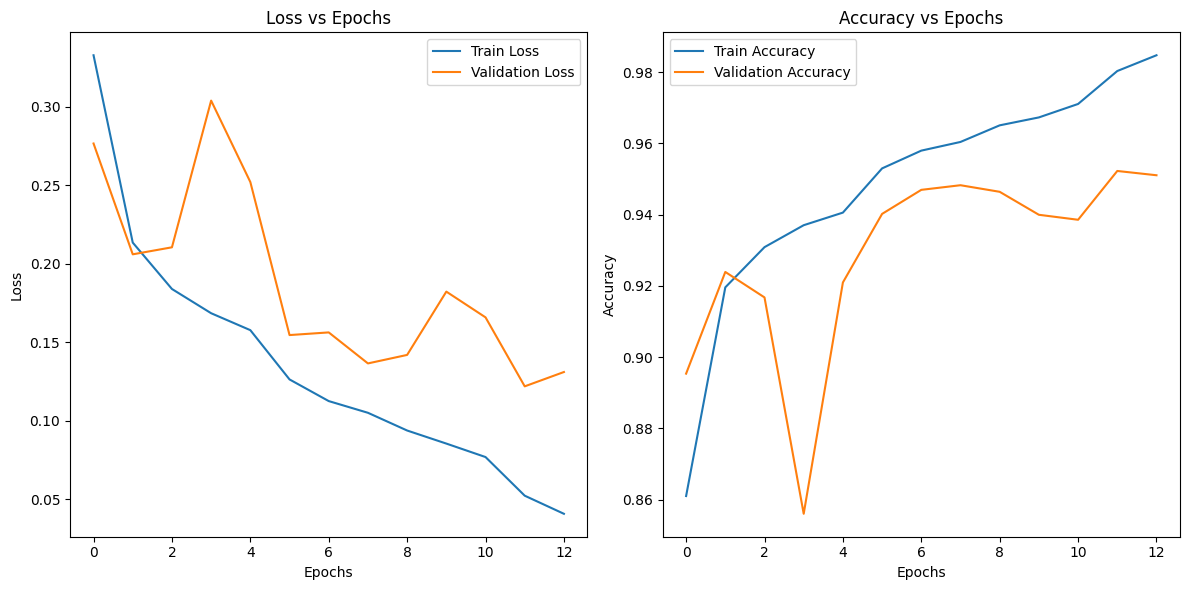

In [62]:
# Train model
history = model.fit(
    [train_images, train_wavelet],
    train_labels,
    epochs=13,
    batch_size=64,
    validation_data=([val_images, val_wavelet], val_labels),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate([val_images, val_wavelet], val_labels)
print(f'Validation set accuracy: {test_acc:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
#Saving the model
model.save('hybrid_resnet_wavelet_model_saved.h5')
print("Model saved successfully!")


Model saved successfully!


Testing the Code on CIFAKE dataset(test images)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9537 - loss: 0.1220
Test accuracy: 0.9546
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


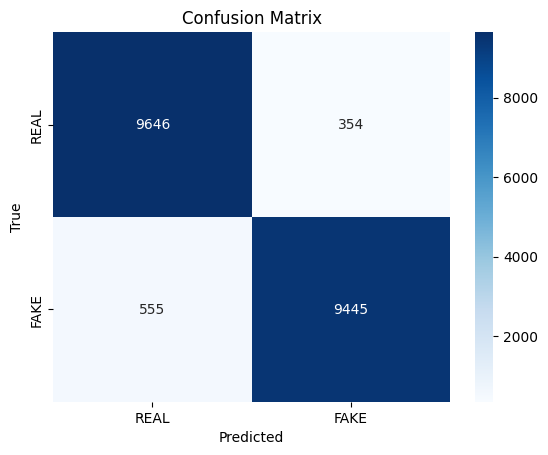


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10000
           1       0.96      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

Index: 4587, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.0040


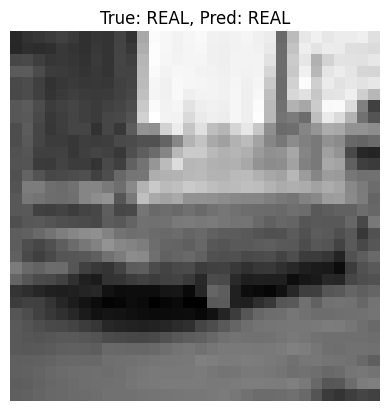

Index: 16967, True Label: FAKE, Predicted Label: FAKE, Prediction Value: 0.8333


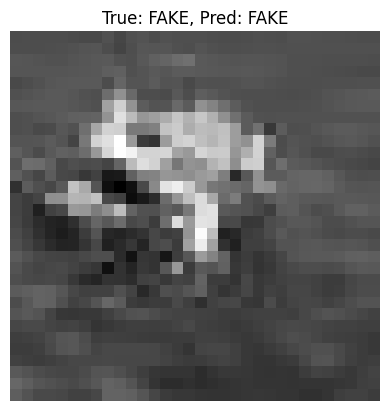

Index: 3597, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.0203


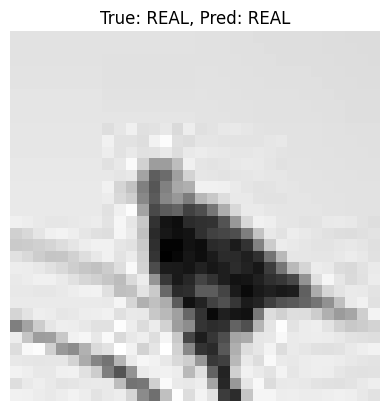

Index: 11909, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.0062


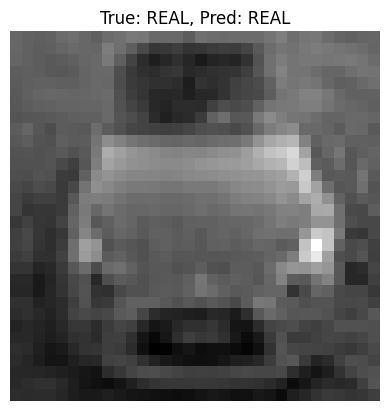

Index: 10864, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.0529


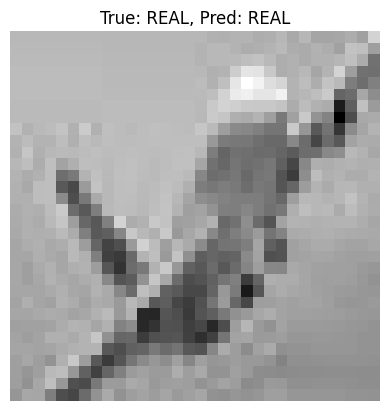

Index: 10172, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.1187


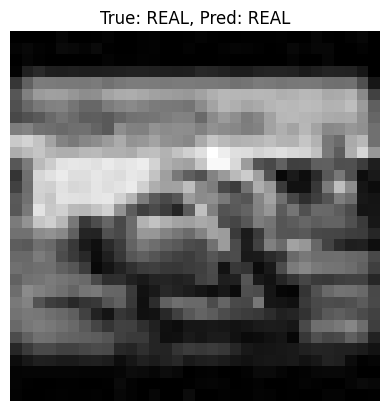

Index: 16667, True Label: FAKE, Predicted Label: FAKE, Prediction Value: 0.9942


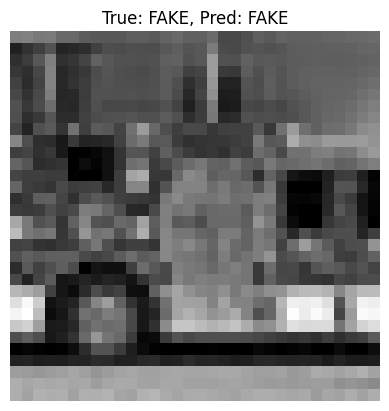

Index: 12649, True Label: REAL, Predicted Label: FAKE, Prediction Value: 0.8621


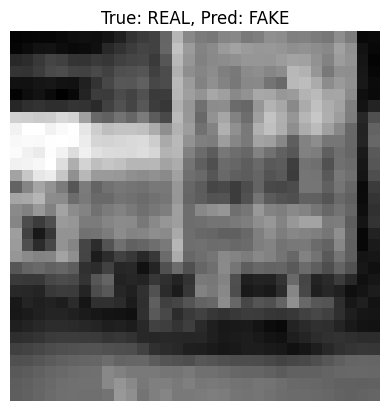

Index: 5261, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.0001


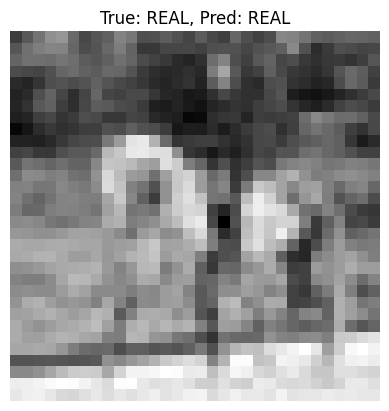

Index: 13028, True Label: REAL, Predicted Label: REAL, Prediction Value: 0.0853


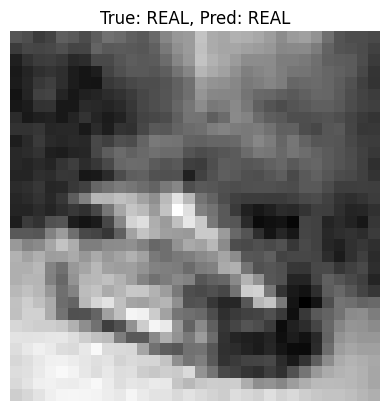

In [64]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing pipeline
def load_images_grayscale_from_directory(real_dir, fake_dir, label_real=0, label_fake=1, image_size=(32, 32)):
    real_images, fake_images = [], []
   
    # Load REAL images
    real_filenames = os.listdir(real_dir)
    random.shuffle(real_filenames)
    for filename in real_filenames:
        img_path = os.path.join(real_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if image is not None:
            image = cv2.resize(image, image_size)  # Resize image
            image = image / 255.0  # Normalize
            real_images.append(image)
   
    # Load FAKE images
    fake_filenames = os.listdir(fake_dir)
    random.shuffle(fake_filenames)
    for filename in fake_filenames:
        img_path = os.path.join(fake_dir, filename)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        if image is not None:
            image = cv2.resize(image, image_size)  # Resize image
            image = image / 255.0  # Normalize
            fake_images.append(image)

    images = np.array(real_images + fake_images)
    labels = np.array([label_real] * len(real_images) + [label_fake] * len(fake_images))
   
    return images, labels

# Loading the Data
real_dir_test = '/home/sds-ws/Adobe_techmeet/test/REAL'  
fake_dir_test = '/home/sds-ws/Adobe_techmeet/test/FAKE'  

test_images, test_labels = load_images_grayscale_from_directory(real_dir_test, fake_dir_test)

# Shuffling the dataset to show that the model is unbiased
indices = np.random.permutation(len(test_images))
test_images = test_images[indices]
test_labels = test_labels[indices]

# Extract wavelet features for the test set
stacked_wavelet_features_test = extract_features_and_stack(test_images)

# Reshape CNN input (test images) and wavelet input (test features) for inputing it to the mdoel
cnn_input_images_test = test_images.reshape(test_images.shape[0], 32, 32, 1)  
wavelet_input_features_test = stacked_wavelet_features_test  

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([cnn_input_images_test, wavelet_input_features_test], test_labels)
print(f'Test accuracy: {test_acc:.4f}')

# Get predictions for the test set
test_predictions = model.predict([cnn_input_images_test, wavelet_input_features_test])

# Convert predictions to binary (REAL: 0, FAKE: 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)


# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions_binary))



# Print the results for these 10 random samples just to check the results
random_indices = np.random.choice(len(test_labels), 10, replace=False)
for i in random_indices:
    true_label = test_labels[i]
    predicted_label = test_predictions_binary[i][0] 
    prediction_value = test_predictions[i][0]  # Raw prediction value

    # Print the result
    print(f"Index: {i}, True Label: {'REAL' if true_label == 0 else 'FAKE'}, Predicted Label: {'REAL' if predicted_label == 0 else 'FAKE'}, Prediction Value: {prediction_value:.4f}")
    
    # Display the image
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"True: {'REAL' if true_label == 0 else 'FAKE'}, Pred: {'REAL' if predicted_label == 0 else 'FAKE'}")
    plt.axis('off')
    plt.show()




Testing on CIFAR-10 (all real images)

In [65]:
# Preprocessing Pipline
def extract_wavelet_features(image, wavelet='bior1.3'):
    coeffs2 = pywt.dwt2(image, wavelet)
    LL, (LH, HL, HH) = coeffs2  # Decompose into 4 sub-bands (LL, LH, HL, HH)
   
    # Flatten each coefficient and concatenate them into a feature vector
    LL_flat = LL.flatten()
    LH_flat = LH.flatten()
    HL_flat = HL.flatten()
    HH_flat = HH.flatten()
   
    features = np.concatenate([LL_flat, LH_flat, HL_flat, HH_flat])
   
    return features

def extract_features_and_stack(images, wavelet='bior1.3'):
    all_features = []
    for image in images:
        features = extract_wavelet_features(image, wavelet)
        all_features.append(features)
   
    stacked_features = np.vstack(all_features)
    return stacked_features

# Load CIFAR-10 data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

# CIFAR-10 images are RGB, but the model expects grayscale images, so we need to convert them.
def rgb_to_grayscale(images):
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])  # Convert RGB to grayscale

# Convert CIFAR-10 test data to grayscale
test_images_grayscale = rgb_to_grayscale(test_data)

# Resize CIFAR-10 test images to match the expected input size (32x32)
test_images_resized = np.array([cv2.resize(image, (32, 32)) for image in test_images_grayscale])

# Normalize the pixel values to [0, 1]
test_images_resized = test_images_resized / 255.0

# Extract wavelet features for the test images
stacked_wavelet_features_test = extract_features_and_stack(test_images_resized)

# Reshape CNN input (test images) and wavelet input (test features)
cnn_input_images_test = test_images_resized.reshape(test_images_resized.shape[0], 32, 32, 1)  # Add channel dimension for CNN
wavelet_input_features_test = stacked_wavelet_features_test  # These are the wavelet features already stacked

# Perform predictions using the model
test_predictions = model.predict([cnn_input_images_test, wavelet_input_features_test])

# Convert predictions to binary (REAL: 0, FAKE: 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

count=0
for i in test_predictions_binary:
    if i==0:
        count=count+1

print("Accuracy:",count/len(test_images_grayscale))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.9469
